In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
#reading in real world splits for comparison
male_sprints=pd.read_csv(r"C:\Users\mgang\Downloads\male_sprints.csv")
female_sprints=pd.read_csv(r"C:\Users\mgang\Downloads\female_sprints.csv")
male_sprints



,Performance,30m,60m,80m,30-60m,60-80m,80-100m,60-100m
0,9.58,3.78,6.31,7.92,2.53,1.61,1.66,3.27
1,9.71-9.80,3.82,6.37,8.05,2.55,1.68,1.72,3.40
2,9.81-9.90,3.83,6.42,8.12,2.60,1.70,1.75,3.45
3,9.91-10.00,3.85,6.46,8.18,2.61,1.73,1.77,3.50
4,10.01-10.10,3.89,6.51,8.26,2.62,1.74,1.79,3.54
5,10.11-10.20,3.95,6.60,8.36,2.64,1.75,1.81,3.57


In [32]:
for df in [male_sprints, female_sprints]:
    #v_max estimated using 30-60m split since it has the fastest time out of all splits
    df['v_max']=30/df['30-60m']
    df['100m']=df['30m']+df['30-60m']+df['60-100m']
    #v_t uses time from 0-30;since we are using avg time over 0-30 meters, we can use the average position between 0 and 30 meters, 15 meters
    df['v_t']=30/df['30m']
    df['tau']= ((df['30m']/2)/np.log(1-(df['v_t']/df['v_max']))*-1)-0.4

female_sprints

,Performance,30m,60m,80m,30-60m,60-80m,80-100m,60-100m,v_max,100m,v_t,tau
0,10.61-10.70,4.07,6.89,8.76,2.82,1.87,1.90,3.78,10.638298,10.67,7.371007,1.323847
1,10.71-10.80,4.10,6.94,8.83,2.84,1.88,1.93,3.82,10.563380,10.76,7.317073,1.337472
2,10.81-10.90,4.17,6.99,8.89,2.85,1.90,1.95,3.86,10.526316,10.88,7.194245,1.412595
3,10.91-11.00,4.17,7.05,8.97,2.87,1.92,1.99,3.92,10.452962,10.96,7.194245,1.388852
4,11.01-11.10,4.18,7.09,9.03,2.89,1.94,2.01,3.95,10.380623,11.02,7.177033,1.377711
5,11.11-11.20,4.20,7.15,9.13,2.95,1.98,2.04,4.02,10.169492,11.17,7.142857,1.332758


In [5]:
def simulate_group(v_max, tau, stop_time=12, dt=0.001):
    
    time= np.arange(0, stop_time, dt)
    #velocity at each time step, vectorized so no need for loop
    v_sim= vmax * (1 - np.exp(-time / tau))

    x_sim = np.zeros_like(time)
    #x position at each time step, loop needed since next step depends on previous
    for i in range(1, len(time)):
        x_sim[i] = x_sim[i-1] + v_sim[i] * dt

    return time, v_sim, x_sim
#for storage of simulated splits for comparison with original data
female_results=[]
male_results=[]

#storing time, v_sim, x_sim, labels
all_times=[]
all_v_sim=[]
all_x_sim=[]
all_labels=[]


for df, results in [(male_sprints, male_results),
                    (female_sprints, female_results)]:

    for idx, row in df.iterrows():

        label = row['Performance']
        vmax = row['v_max']
        tau  = row['tau']

        # run the simulation
        time, v_sim, x_sim = simulate_group(vmax, tau)

        all_times.append(time)
        all_x_sim.append(x_sim)
        all_v_sim.append(v_sim)
        all_labels.append(label)


        # function to extract split time
        def get_split(dist):
            return time[np.where(x_sim >= dist)[0][0]]

        # compute model splits
        model_30  = get_split(30)
        model_60  = get_split(60)
        model_80  = get_split(80)
        model_100 = get_split(100)
        


        # save output
        results.append({
            'Performance': label,
            'Pred_30m': model_30,
            'Pred_60m': model_60,
            'Pred_80m': model_80,
            'Pred_100m': model_100,
        })
        
male_results_sim = pd.DataFrame(male_results)
female_results_sim = pd.DataFrame(female_results)

print(male_results_sim)
print(female_results_sim)

   Performance  Pred_30m  Pred_60m  Pred_80m  Pred_100m
0         9.58     3.764     6.358     8.052      9.741
1    9.71-9.80     3.807     6.424     8.131      9.834
2    9.81-9.90     3.820     6.478     8.217      9.952
3   9.91-10.00     3.842     6.510     8.257      9.998
4  10.01-10.10     3.884     6.568     8.322     10.070
5  10.11-10.20     3.948     6.658     8.426     10.189
   Performance  Pred_30m  Pred_60m  Pred_80m  Pred_100m
0  10.61-10.70     4.083     6.957     8.842     10.723
1  10.71-10.80     4.116     7.010     8.909     10.804
2  10.81-10.90     4.190     7.103     9.010     10.912
3  10.91-11.00     4.191     7.121     9.040     10.955
4  11.01-11.10     4.202     7.150     9.082     11.011
5  11.11-11.20     4.227     7.227     9.198     11.166


In [37]:
#merging the actual and simulated times at each split, but removing the actual splits for male and female df
male_sprint_times=male_sprints[['Performance','30m', '60m', '80m', '100m']]
male_sprint_times_and_pred=pd.merge(male_sprint_times, male_results_sim, on='Performance')

female_sprint_times=female_sprints[['Performance','30m', '60m', '80m', '100m']]
female_sprint_times_and_pred=pd.merge(female_sprint_times, female_results_sim, on='Performance')

def add_error_columns(df):
    df['Error_30m']  = df['Pred_30m']  - df['30m']
    df['Error_60m']  = df['Pred_60m']  - df['60m']
    df['Error_80m']  = df['Pred_80m']  - df['80m']
    df['Error_100m'] = df['Pred_100m'] - df['100m']

    df['PctErr_30m']  = df['Error_30m']  / df['30m']  * 100
    df['PctErr_60m']  = df['Error_60m']  / df['60m']  * 100
    df['PctErr_80m']  = df['Error_80m']  / df['80m']  * 100
    df['PctErr_100m'] = df['Error_100m'] / df['100m'] * 100

    return df
male_errors   = add_error_columns(male_sprint_times_and_pred)
female_errors = add_error_columns(female_sprint_times_and_pred)
female_errors

,Performance,30m,60m,80m,100m,Pred_30m,Pred_60m,Pred_80m,Pred_100m,Error_30m,Error_60m,Error_80m,Error_100m,PctErr_30m,PctErr_60m,PctErr_80m,PctErr_100m
0,10.61-10.70,4.07,6.89,8.76,10.67,4.083,6.957,8.842,10.723,0.013,0.067,0.082,0.053,0.319410,0.972424,0.936073,0.496720
1,10.71-10.80,4.10,6.94,8.83,10.76,4.116,7.010,8.909,10.804,0.016,0.070,0.079,0.044,0.390244,1.008646,0.894677,0.408922
2,10.81-10.90,4.17,6.99,8.89,10.88,4.190,7.103,9.010,10.912,0.020,0.113,0.120,0.032,0.479616,1.616595,1.349831,0.294118
3,10.91-11.00,4.17,7.05,8.97,10.96,4.191,7.121,9.040,10.955,0.021,0.071,0.070,-0.005,0.503597,1.007092,0.780379,-0.045620
4,11.01-11.10,4.18,7.09,9.03,11.02,4.202,7.150,9.082,11.011,0.022,0.060,0.052,-0.009,0.526316,0.846262,0.575858,-0.081670
5,11.11-11.20,4.20,7.15,9.13,11.17,4.227,7.227,9.198,11.166,0.027,0.077,0.068,-0.004,0.642857,1.076923,0.744797,-0.035810


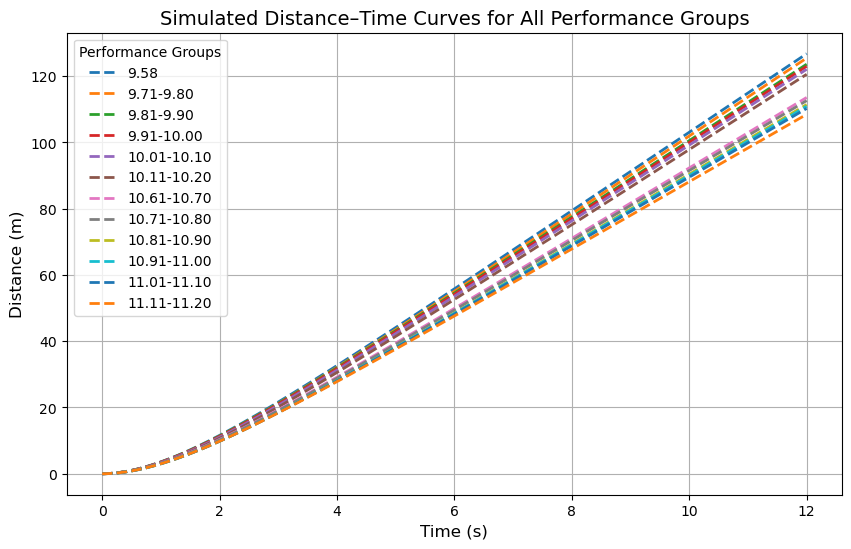

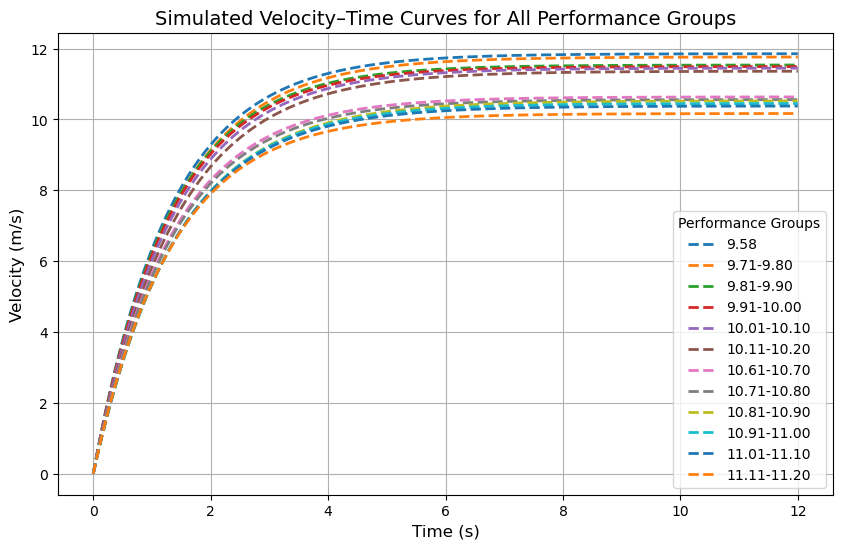

In [22]:
# Distance over time plot
plt.figure(figsize=(10,6))

for time, x_sim, label in zip(all_times, all_x_sim, all_labels):
    plt.plot(time, x_sim, linewidth=2, label=label, linestyle='--')

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Distance (m)', fontsize=12)
plt.title('Simulated Distance–Time Curves for All Performance Groups', fontsize=14)
plt.legend(title="Performance Groups")
plt.grid(True)
plt.savefig("Distance_time.png", dpi=300, bbox_inches='tight')

plt.show()

#Velocity over time plot
plt.figure(figsize=(10,6))

for time, v_sim, label in zip(all_times, all_v_sim, all_labels):
    plt.plot(time, v_sim, linewidth=2, label=label, linestyle='--')

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Velocity (m/s)', fontsize=12)
plt.title('Simulated Velocity–Time Curves for All Performance Groups', fontsize=14)
plt.savefig("Velocity_time.png", dpi=300, bbox_inches='tight')

plt.legend(title="Performance Groups")
plt.grid(True)
plt.show()



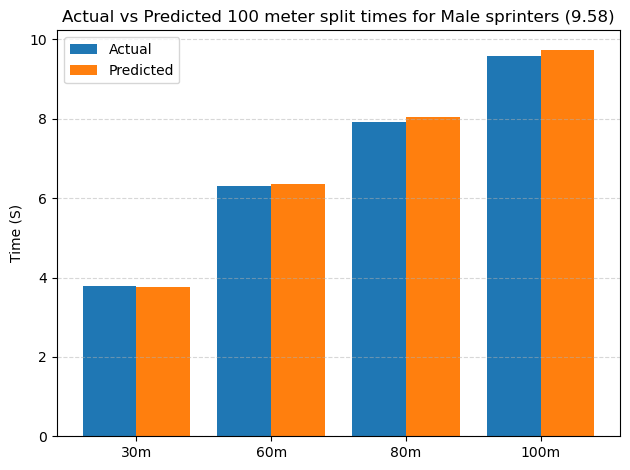

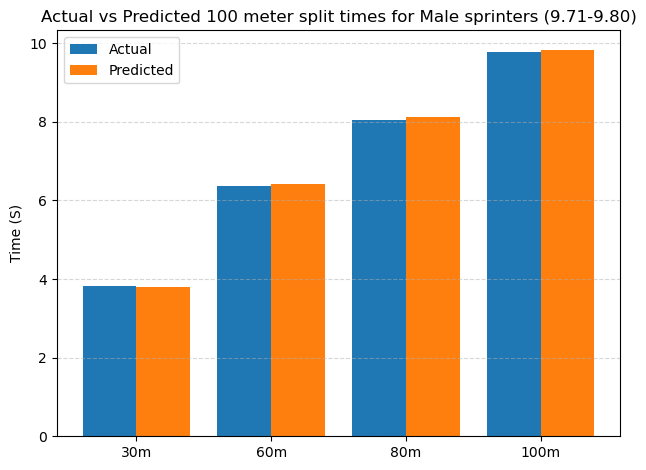

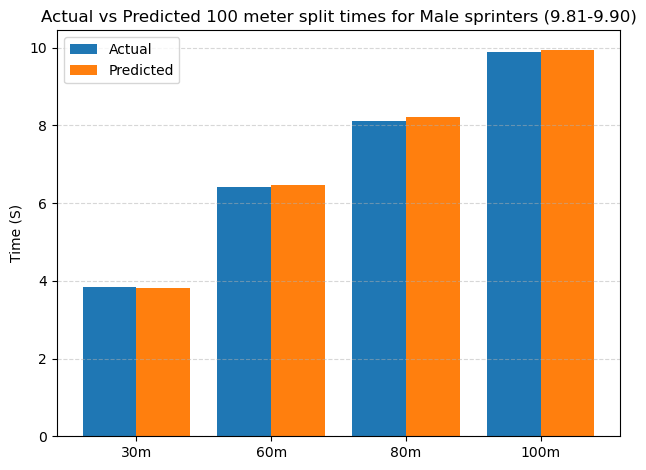

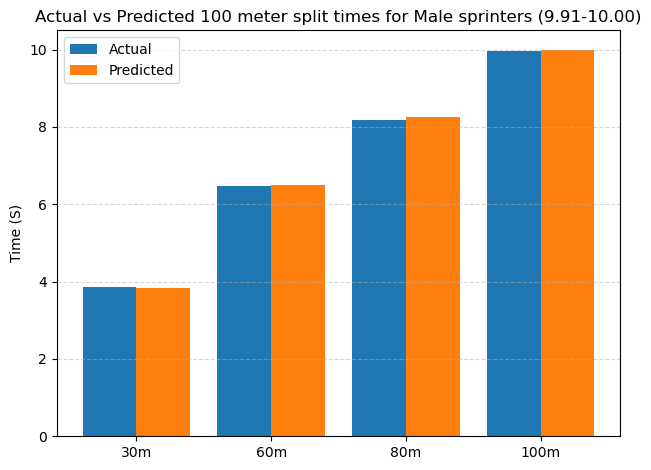

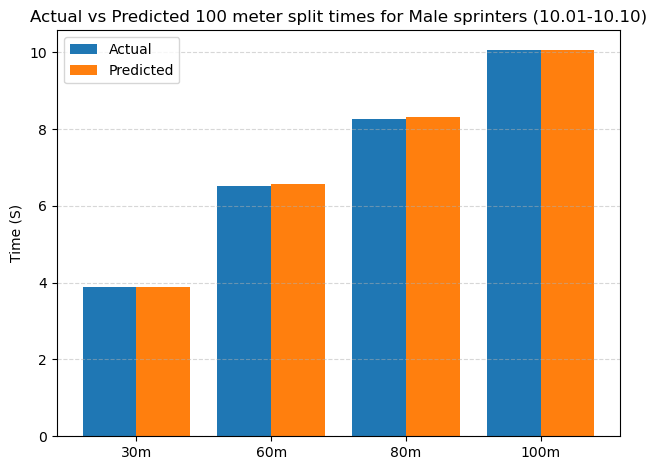

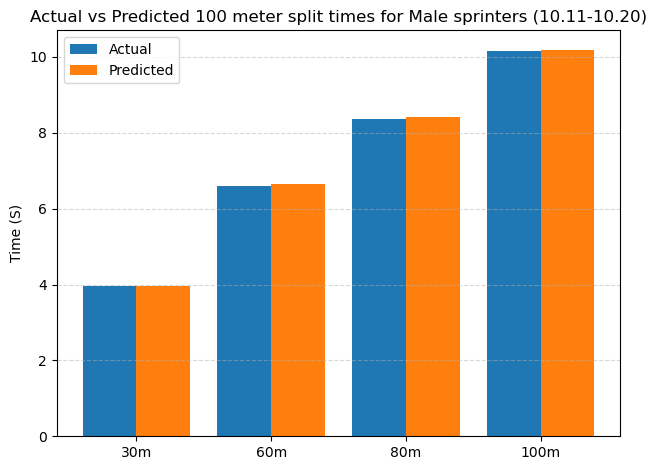

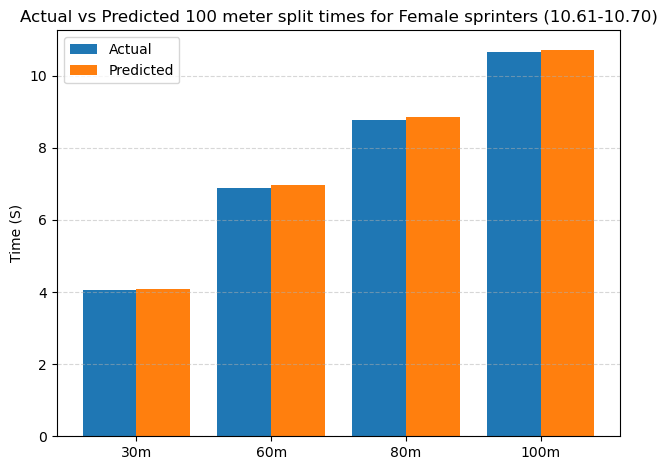

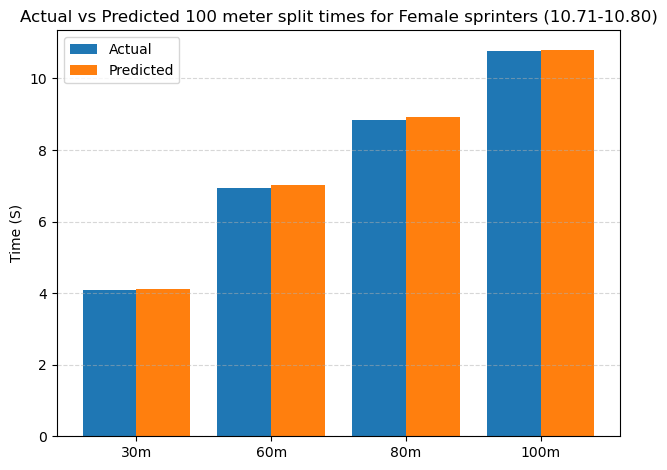

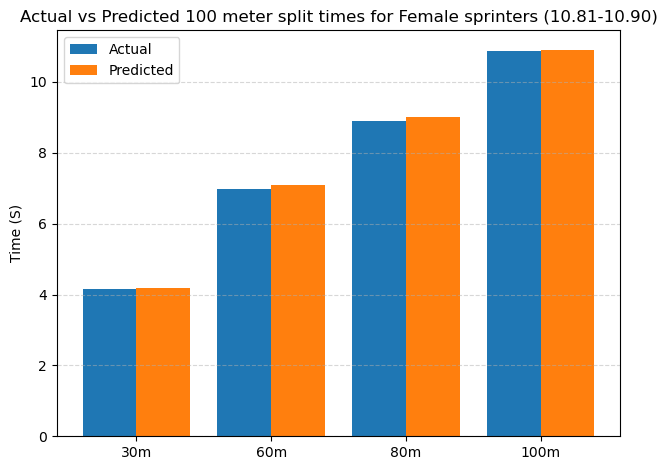

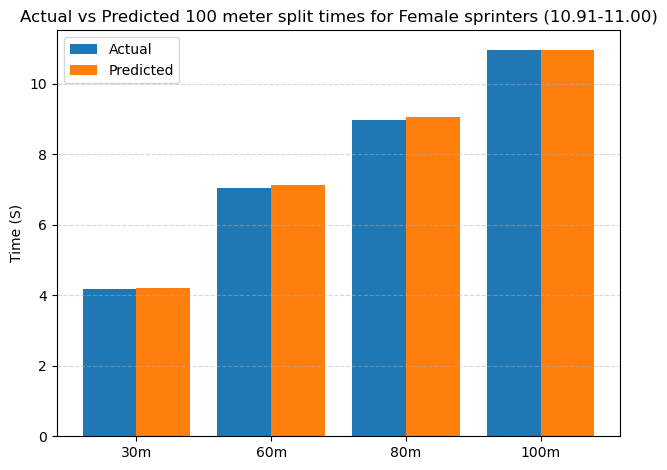

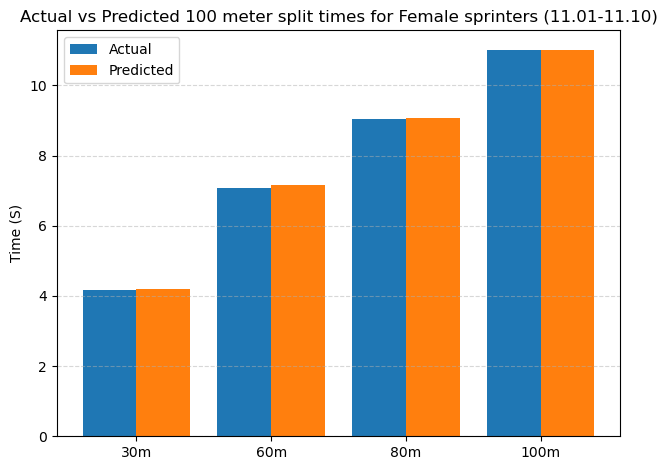

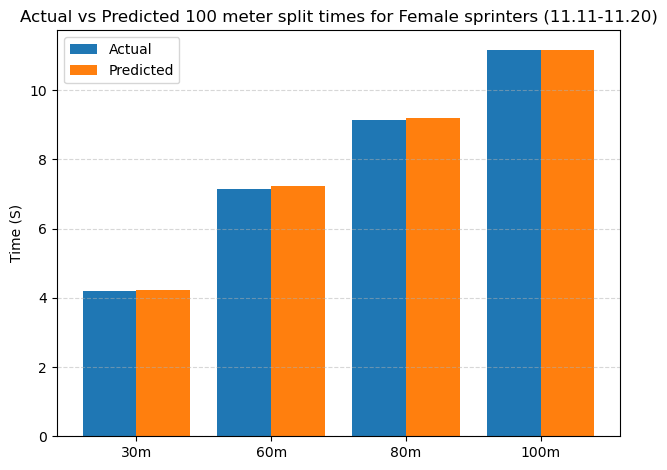

In [8]:
for df, label in [(male_errors, 'Male'), (female_errors, 'Female')]:
    distances = ["30m", "60m", "80m", "100m"]
    for idx, row in df.iterrows():
        performance_group=row['Performance']
        acc_times=[row['30m'],
                   row['60m'],
                   row['80m'],
                   row['100m']]
        pred_times=[row['Pred_30m'],
                   row['Pred_60m'],
                   row['Pred_80m'],
                   row['Pred_100m']]
        

        x=np.arange(len(distances))
        width=0.4
        plt.bar(x - width/2, acc_times, width, label='Actual')
        plt.bar(x + width/2, pred_times, width, label='Predicted')

        plt.xticks(x,distances)
        plt.ylabel('Time (S)')
        plt.title(f'Actual vs Predicted 100 meter split times for {label} sprinters ({performance_group})')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()
        